# Artificial Neural Networks and Deep Learning

---

## Homework 1: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.
2. Upload the `training_set.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.zip` file to Codabench.


## 🌐 Connect Colab to Google Drive

In [2]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 1


## ⚙️ Import Libraries

In [3]:
pip install keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 13.4 MB/s eta 0:00:00


In [4]:
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import mixed_precision

import keras_cv as kcv
import pandas as pd
import random
from sklearn.model_selection import train_test_split

seed = 42

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

np.random.seed(seed)
tf.random.set_seed(seed);

2.17.1


## ⏳ Load the Data

In [5]:
data = np.load('training_set.npz')
X = data['images'] # Array of 13759 images (96x96x3 each)
y = data['labels'] # Array of 13759 labels (numbers from 0 to 7)

# Remove all the main outliers
X = X[:11959]
y = y[:11959]


unique_images = {}
filtered_indices = []

# Find all remaining duplicate images
for i in range(len(X)):
    img = X[i].tobytes()
    if img not in unique_images:
        unique_images[img] = y[i]
        filtered_indices.append(i)
    elif unique_images[img] != y[i]:
        continue

X_filtered = X[filtered_indices]
y_filtered = y[filtered_indices]

# Remove all copied images
unique_pairs = set()
final_indices = []

for i in range(len(X_filtered)):
    img_label_pair = (X_filtered[i].tobytes(), y_filtered[i].item)
    if img_label_pair not in unique_pairs:
        unique_pairs.add(img_label_pair)
        final_indices.append(i)

# Filter the dataset to remove the duplicates
X = X_filtered[final_indices]
y = y_filtered[final_indices]

TEST_SIZE = round(X.shape[0] / 20) # 5%
VAL_SIZE = round(X.shape[0] / 10) # 10%

# Split the dataset into a combined training and validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=seed,
    stratify=y
)

# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=VAL_SIZE,
    random_state=seed,
    stratify=y_train_val
)

class_names = ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']

from sklearn.utils.class_weight import compute_class_weight
y_cw = np.squeeze(y_train)

classes = np.unique(y_cw)
# Class weights - for mitigating unbalanced classes
class_weights = compute_class_weight('balanced', classes=classes, y=y_cw)
# Convert to dictionary
class_weight_dict = dict(zip(classes, class_weights))
print("Class Weights: "+str(class_weight_dict))

# Convert class labels to categorical format for training, validation, and test sets
y_train = tfk.utils.to_categorical(y_train, num_classes=len(class_names))
y_val = tfk.utils.to_categorical(y_val, num_classes=len(class_names))
y_test = tfk.utils.to_categorical(y_test, num_classes=len(class_names))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Class Weights: {0: 1.7586565096952909, 1: 0.6856101511879049, 2: 1.377169197396963, 3: 0.7382267441860465, 4: 1.7586565096952909, 5: 1.5062277580071175, 6: 0.6412878787878787, 7: 0.9089119541875448}
X_train shape: (10158, 96, 96, 3), y_train shape: (10158, 8)
X_val shape: (1195, 96, 96, 3), y_val shape: (1195, 8)
X_test shape: (598, 96, 96, 3), y_test shape: (598, 8)


In [ ]:
BATCH_SIZE = 64
INPUT_SHAPE = (96, 96, 3)
NUM_CLASSES = 8

# Preprocessing Augmenter - Keras CV layers
augmenter = kcv.layers.Augmenter(
    [
        kcv.layers.RandomFlip(),
        kcv.layers.RandAugment(value_range=(0, 255), magnitude=0.2, augmentations_per_image=4),
        kcv.layers.CutMix(),
    ],
)

# Applies the augmenter
def preprocess_data(images, labels, augment=False):
    inputs = {"images": images, "labels": labels}
    outputs = inputs
    if augment:
        outputs = augmenter(outputs)
    return outputs['images'], outputs['labels']

# Perforom the Augmentation using the Keras CV layers
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

dataset = dataset.batch(BATCH_SIZE).map(
    lambda x, y: preprocess_data(x, y, augment=True),
        num_parallel_calls=tf.data.AUTOTUNE).prefetch(
            tf.data.AUTOTUNE)

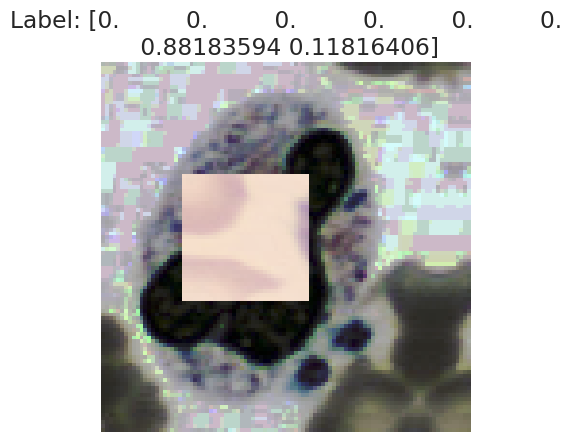

In [ ]:
import matplotlib.pyplot as plt

# Get a single batch from the dataset
for image, label in dataset.take(1):  # Take one batch (or one element if unbatched)
    # If the dataset is batched, take the first image in the batch
    if len(image.shape) == 4:  # Batch shape: (batch_size, height, width, channels)
        image = image[0]  # Take the first image in the batch
        label = label[0]  # Take the corresponding label

    # Display the image
    plt.imshow(image.numpy().astype("uint8"))  # Convert to NumPy and cast to uint8
    plt.title(f"Label: {label.numpy()}")  # Convert the label to NumPy for display
    plt.axis('off')  # Turn off axis
    plt.show()
    break  # Exit after visualizing one image

Initialise EfficientNetB0 model with pretrained weights, for transfer learning

In [ ]:
# Initialise EfficientNetB0 model with pretrained weights, for transfer learning
efficientnet = tfk.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    classes=NUM_CLASSES,
    classifier_activation="softmax",
)
# Freeze all layers in EfficientNetB0 to use it solely as a feature extractor
efficientnet.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=INPUT_SHAPE, name='input_layer')

# Augmentation Pipeline with keras.sequential - make the data augmentation process more robust than before
augmentation = tf.keras.Sequential([
    tfkl.Resizing(224, 224),
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.1,0.1),
    tfkl.RandomRotation(0.1),
    tfkl.RandomZoom(0.1),
], name='preprocessing')

# Pass augmented inputs through the EfficientNetB0 feature extractor
x = augmentation(inputs)
x = efficientnet(x)

# Add a global average pooling
x = tfkl.GlobalAveragePooling2D(name='gap')(x)
# Add a dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout')(x)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Lion(1e-4), metrics=['accuracy'])

# Display a summary of the model architecture
tl_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
#tfk.utils.plot_model(tl_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ resizing (Resizing)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip_1 (RandomFlip)      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation_2            │ (None, 224, 224, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation                 │ (None, 224, 224, 3)         │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom (RandomZoom)        │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ normalization (Normalization)   │ (None, None, None, 3)       │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling_1 (Rescaling)         │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv_pad (ZeroPadding2D)   │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, None, None, 32)      │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, None, None, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_dwconv                  │ (None, None, None, 32)      │             288 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_bn (BatchNormalization) │ (None, None, None, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_activation (Activation) │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_se_squeeze              │ (None, 32)                  │              

 Total params: 4,059,819 (15.49 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 🛠️ Train and Save the Model

In [ ]:
# Add your implementation here
model = tl_model

# Train the model
history = model.fit(
    dataset,
    batch_size = 64,
    epochs = 1000,
    validation_data = (X_val, y_val),
    class_weight = class_weight_dict,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

Epoch 1/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 118s 594ms/step - accuracy: 0.1706 - loss: 2.1587 - val_accuracy: 0.5711 - val_loss: 1.5379
Epoch 2/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 134s 588ms/step - accuracy: 0.3448 - loss: 1.8410 - val_accuracy: 0.7065 - val_loss: 1.1640
Epoch 3/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 141s 580ms/step - accuracy: 0.4201 - loss: 1.7130 - val_accuracy: 0.7818 - val_loss: 0.9476
Epoch 4/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 95s 584ms/step - accuracy: 0.4592 - loss: 1.6575 - val_accuracy: 0.7876 - val_loss: 0.8716
Epoch 5/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 143s 586ms/step - accuracy: 0.4686 - loss: 1.6258 - val_accuracy: 0.8069 - val_loss: 0.8273
Epoch 6/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 106s 659ms/step - accuracy: 0.4885 - loss: 1.5894 - val_accuracy: 0.8344 - val_loss: 0.7702
Epoch 7/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 141s 647ms/step - accuracy: 0.5002 - loss: 1.5727 - val_accuracy: 0.8378 - val_loss: 0.7446
Epoch 8/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 130s 576ms/step - acc

In [ ]:
# Only save if its useful
model.save('weights.keras')
del model

In [ ]:
# Re-load the model after transfer learning (practical due to GPUs' limited access)
ft_model = tfk.models.load_model('weights.keras')
#ft_model.save('withnorm.keras')
# Display a summary of the model architecture
ft_model.summary(expand_nested=True)


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ resizing (Resizing)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip_1 (RandomFlip)      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation_2            │ (None, 224, 224, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation                 │ (None, 224, 224, 3)         │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom (RandomZoom)        │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ normalization (Normalization)   │ (None, None, None, 3)       │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling_1 (Rescaling)         │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv_pad (ZeroPadding2D)   │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, None, None, 32)      │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, None, None, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_dwconv                  │ (None, None, None, 32)      │             288 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_bn (BatchNormalization) │ (None, None, None, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_activation (Activation) │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_se_squeeze              │ (None, 32)                  │              

 Total params: 4,070,069 (15.53 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 10,250 (40.04 KB)

In [ ]:
# Set the EfficientNetB0 model layers as trainable
ft_model.get_layer('efficientnetb0').trainable = True

# Set all EfficientNetB0 layers as non-trainable
for layer in ft_model.get_layer('efficientnetb0').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer('efficientnetb0').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

5 stem_conv Conv2D True
8 block1a_dwconv DepthwiseConv2D True
13 block1a_se_reduce Conv2D True
14 block1a_se_expand Conv2D True
16 block1a_project_conv Conv2D True
18 block2a_expand_conv Conv2D True
22 block2a_dwconv DepthwiseConv2D True
27 block2a_se_reduce Conv2D True
28 block2a_se_expand Conv2D True
30 block2a_project_conv Conv2D True
32 block2b_expand_conv Conv2D True
35 block2b_dwconv DepthwiseConv2D True
40 block2b_se_reduce Conv2D True
41 block2b_se_expand Conv2D True
43 block2b_project_conv Conv2D True
47 block3a_expand_conv Conv2D True
51 block3a_dwconv DepthwiseConv2D True
56 block3a_se_reduce Conv2D True
57 block3a_se_expand Conv2D True
59 block3a_project_conv Conv2D True
61 block3b_expand_conv Conv2D True
64 block3b_dwconv DepthwiseConv2D True
69 block3b_se_reduce Conv2D True
70 block3b_se_expand Conv2D True
72 block3b_project_conv Conv2D True
76 block4a_expand_conv Conv2D True
80 block4a_dwconv DepthwiseConv2D True
85 block4a_se_reduce Conv2D True
86 block4a_se_expand Conv

In [ ]:
# Set the number of layers to freeze
N = 200
# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('efficientnetb0').layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer('efficientnetb0').layers):
    print(i, layer.name, layer.trainable)

# Display a summary of the model architecture
ft_model.summary(expand_nested=True)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ resizing (Resizing)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip_1 (RandomFlip)      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation_2            │ (None, 224, 224, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation                 │ (None, 224, 224, 3)         │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom (RandomZoom)        │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ normalization (Normalization)   │ (None, None, None, 3)       │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling_1 (Rescaling)         │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv_pad (ZeroPadding2D)   │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, None, None, 32)      │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, None, None, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_dwconv                  │ (None, None, None, 32)      │             288 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_bn (BatchNormalization) │ (None, None, None, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_activation (Activation) │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_se_squeeze              │ (None, 32)                  │              

 Total params: 4,070,069 (15.53 MB)

 Trainable params: 2,047,768 (7.81 MB)

 Non-trainable params: 2,012,051 (7.68 MB)

 Optimizer params: 10,250 (40.04 KB)

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Lion(2e-5), metrics=['accuracy'])

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    dataset,
    batch_size = 128,
    epochs = 1000,
    class_weight = class_weight_dict,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model
ft_model.save('weights.keras')

# Delete the model to free up resources
del ft_model

Epoch 1/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 114s 623ms/step - accuracy: 0.5282 - loss: 1.5378 - val_accuracy: 0.8554 - val_loss: 0.5683
Epoch 2/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 98s 599ms/step - accuracy: 0.5569 - loss: 1.4493 - val_accuracy: 0.8779 - val_loss: 0.4589
Epoch 3/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 140s 586ms/step - accuracy: 0.5754 - loss: 1.4190 - val_accuracy: 0.8863 - val_loss: 0.4184
Epoch 4/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 143s 594ms/step - accuracy: 0.5905 - loss: 1.3751 - val_accuracy: 0.8938 - val_loss: 0.3841
Epoch 5/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 95s 574ms/step - accuracy: 0.6065 - loss: 1.3584 - val_accuracy: 0.9022 - val_loss: 0.3641
Epoch 6/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 144s 590ms/step - accuracy: 0.6216 - loss: 1.3446 - val_accuracy: 0.9164 - val_loss: 0.3318
Epoch 7/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 97s 600ms/step - accuracy: 0.6261 - loss: 1.3213 - val_accuracy: 0.9156 - val_loss: 0.3138
Epoch 8/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 138s 574ms/step - accur

TEST ON THE HOLD OUT TEST SET

In [ ]:
class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 303ms/step
Predictions Shape: (598,)
[2 6 6 7 1 6 7 3 1 7 0 5 5 1 3 3 6 4 3 3 6 4 2 3 2 4 7 7 5 3 3 3 3 0 7 2 6
 5 5 2 7 5 7 5 0 3 3 3 0 0 1 1 3 1 2 7 1 3 1 3 3 3 3 1 7 6 3 5 0 4 5 6 6 3
 0 1 6 3 6 4 1 4 7 6 6 1 3 3 7 6 6 3 3 6 5 4 1 3 1 6 4 3 3 3 1 0 0 7 6 0 3
 1 1 2 3 5 0 6 1 6 1 0 1 0 7 5 1 2 7 7 1 4 1 5 5 3 6 7 5 7 5 2 7 1 6 3 0 5
 5 5 6 6 1 1 1 4 3 6 3 6 1 2 5 6 4 5 7 0 2 1 0 7 7 4 6 7 7 1 3 3 1 3 3 2 0
 0 3 4 4 2 3 2 2 1 6 7 2 1 1 6 6 7 7 1 4 7 4 0 3 6 3 2 3 0 7 1 3 6 7 7 3 4
 1 7 6 1 3 3 6 1 1 6 6 7 1 6 2 4 2 6 2 1 6 3 1 0 2 7 2 0 6 2 3 3 0 6 2 4 3
 7 0 3 2 4 3 7 3 3 4 6 7 2 6 4 1 2 3 6 6 3 6 5 3 1 7 6 3 1 6 1 6 6 1 6 2 6
 4 6 1 7 2 5 0 1 1 5 3 7 4 6 5 3 7 5 1 5 7 7 0 6 0 1 4 6 6 6 6 3 0 6 2 6 2
 7 5 5 3 3 3 4 7 1 3 3 2 7 1 3 4 6 5 3 3 6 6 1 2 0 6 1 1 6 5 4 3 7 1 1 1 0
 7 1 3 5 1 6 3 1 1 7 2 2 6 3 3 1 1 6 6 1 5 1 5 6 6 2 1 4 2 2 0 4 1 6 3 6 2
 6 1 3 2 5 2 7 7 7 1 0 7 6 5 5 3 1 3 0 0 0 6 1 1 7 7 7 7 3 5 1 4 7 7 5 6 6
 6 6 3 6 1 2 6 1 6 1 6 2 1 6 4 6

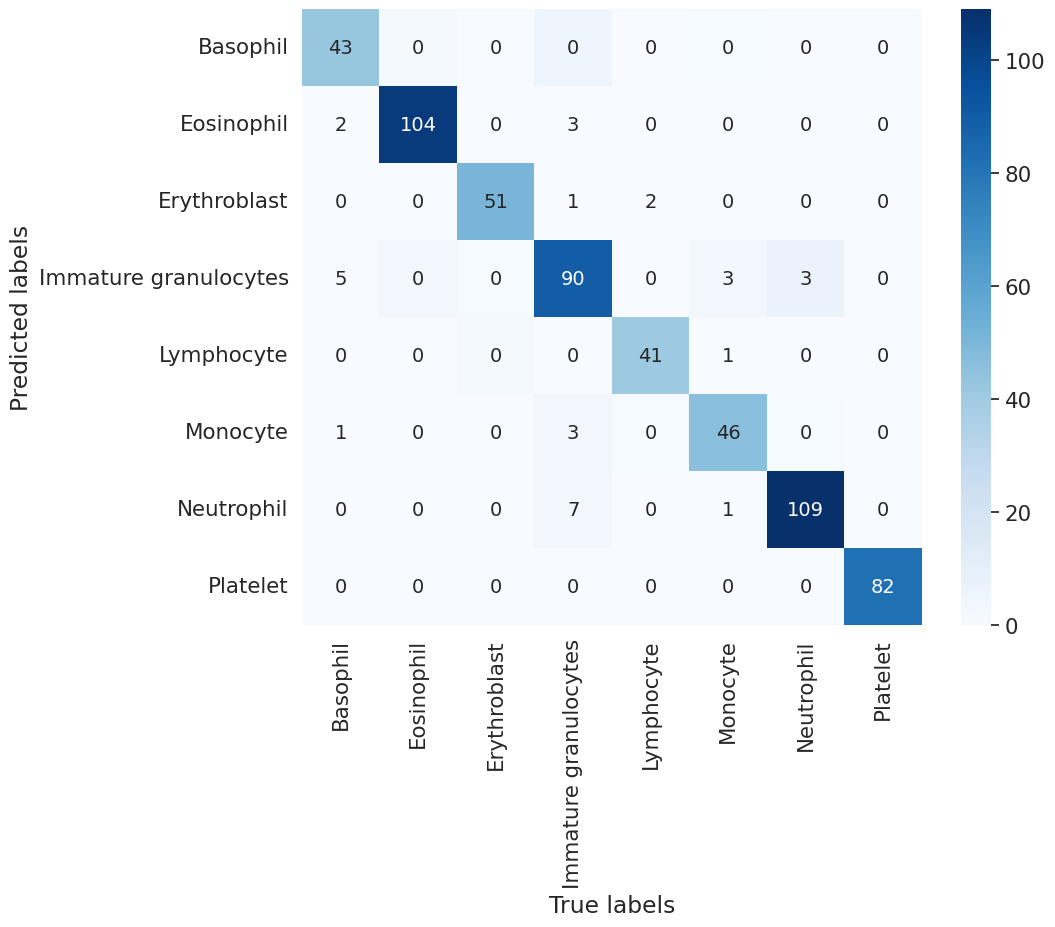

In [ ]:
# Predict labels for the entire test set
model = Model()

predictions = model.predict(X_test)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)
print(true_classes)
# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, predictions)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, predictions, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, predictions, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, predictions, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predictions)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(class_names), yticklabels=list(class_names), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 56%)
  adding: weights.keras (deflated 54%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>